# Setup

In [58]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
options(warn = -1)
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast, mgcv)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

In [6]:
homeownership <- read_homeownership()

test_split <- 4
train_splines <- homeownership %>% head(-test_split)
test_splines <- homeownership %>% tail(test_split)

# Splines Model

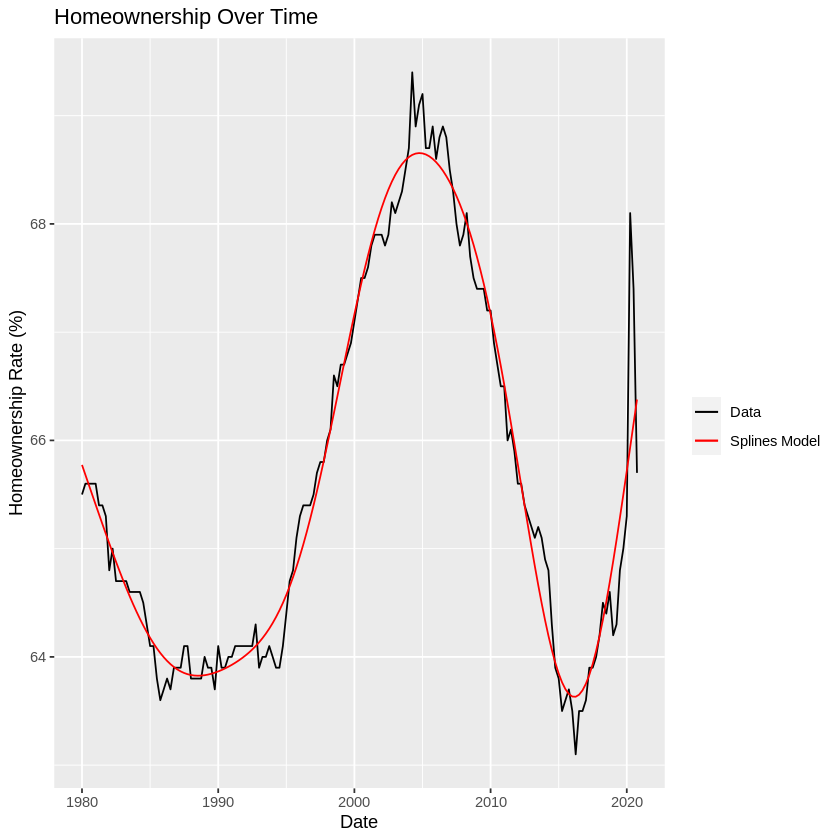

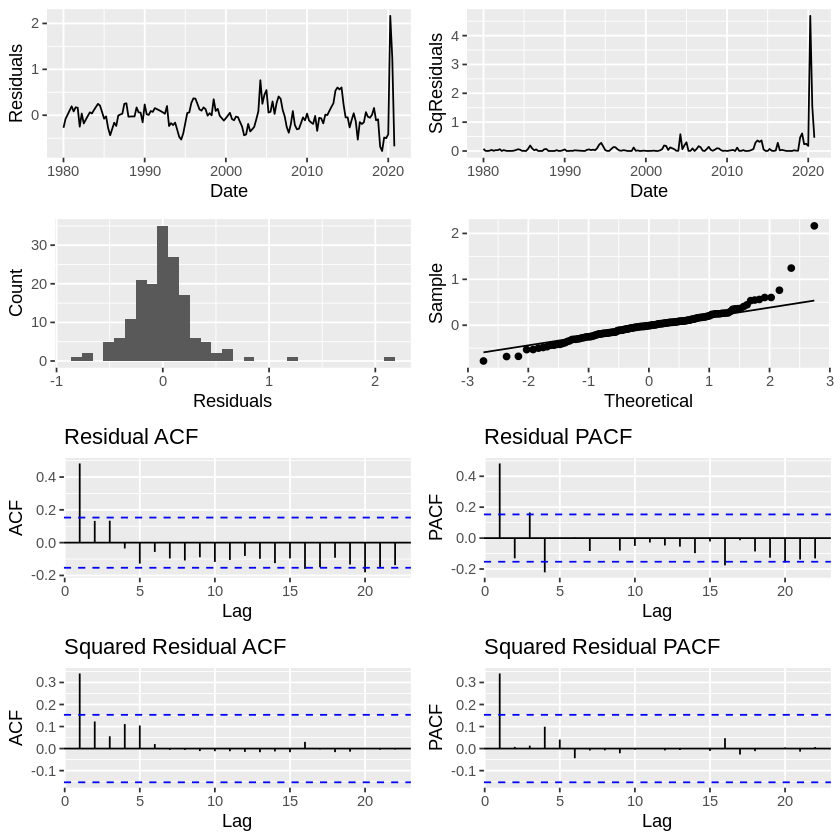

In [7]:
splines_model <- gam(Value ~ s(as.numeric(Date)), data = train_splines)

train_splines %>% ggplot() + 
    geom_line(aes(x = Date, y = Value, color = "Data")) + 
    geom_line(aes(x = Date, y = fitted(splines_model), color = "Splines Model"))+
    labs(x = "Date", y = "Homeownership Rate (%)", title = "Homeownership Over Time") +
    scale_color_manual("", values = c("Data" = "black", "Splines Model" = "red"))

residual_analysis(splines_model, train_splines$Date)

# Training ARIMA

In [9]:
train_resid <- data.frame(Date = train_splines$Date, Residuals <- splines_model$residuals)

In [10]:
arima_comp <- find_best_arima(train_resid$Residuals, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,1,0,5,22.31940
2,2,0,5,23.56874
3,4,0,3,23.98963
4,5,0,3,24.14847
5,3,0,5,25.26284
6,5,0,4,26.33390



	Box-Ljung test

data:  residuals(model)
X-squared = 1.0386, df = 1, p-value = 0.3082


	Box-Ljung test

data:  residuals(model)^2
X-squared = 8.4131, df = 1, p-value = 0.003725



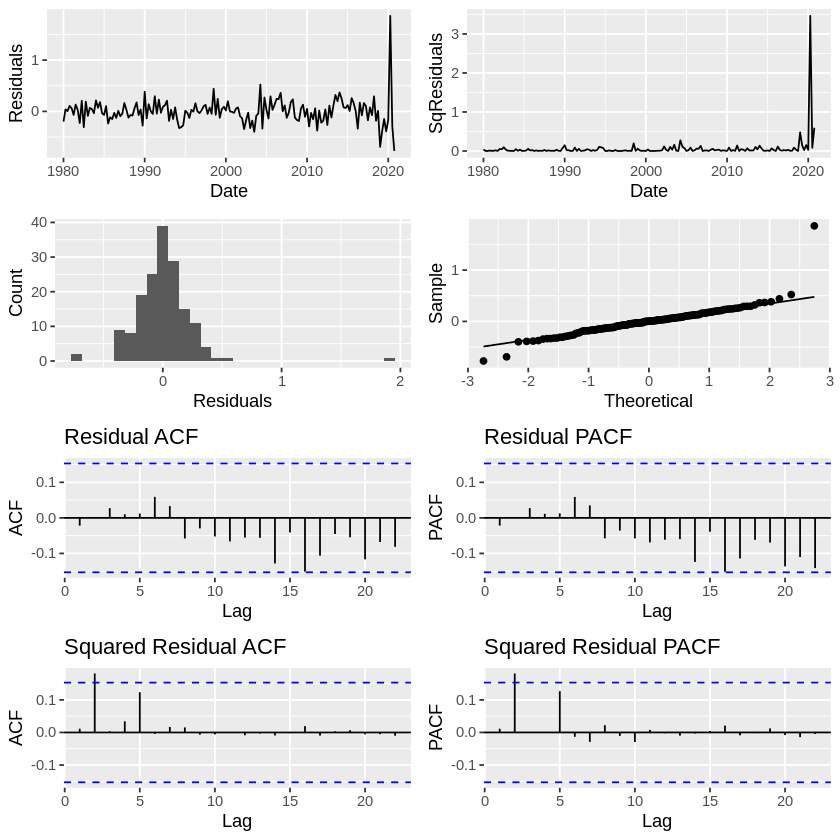

In [11]:
best_order <- as.numeric(arima_comp[1,1:3])
arima_model <- arima(train_resid$Residuals, order = best_order, method = "ML", optim.control = list(maxit = 1000))
residual_analysis(arima_model, train_resid$Date)
box_tests(arima_model, best_order[1] + best_order[3])

# Training ARMA-GARCH

In [12]:
ugarch_comp <- find_best_ugarch(train_resid$Residuals, best_order[1], best_order[3], 0:5, 0:5, 0:2, 0:2)
head(ugarch_comp$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,1,0,1,1,-0.3955965
2,1,0,2,0,-0.3950278
3,1,0,1,0,-0.3898764
4,1,0,0,0,-0.3837122
5,1,0,0,1,-0.3773059
6,1,0,1,2,-0.3648373



	Box-Ljung test

data:  residuals(model)
X-squared = 15.591, df = 1, p-value = 7.862e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 18.788, df = 1, p-value = 1.461e-05



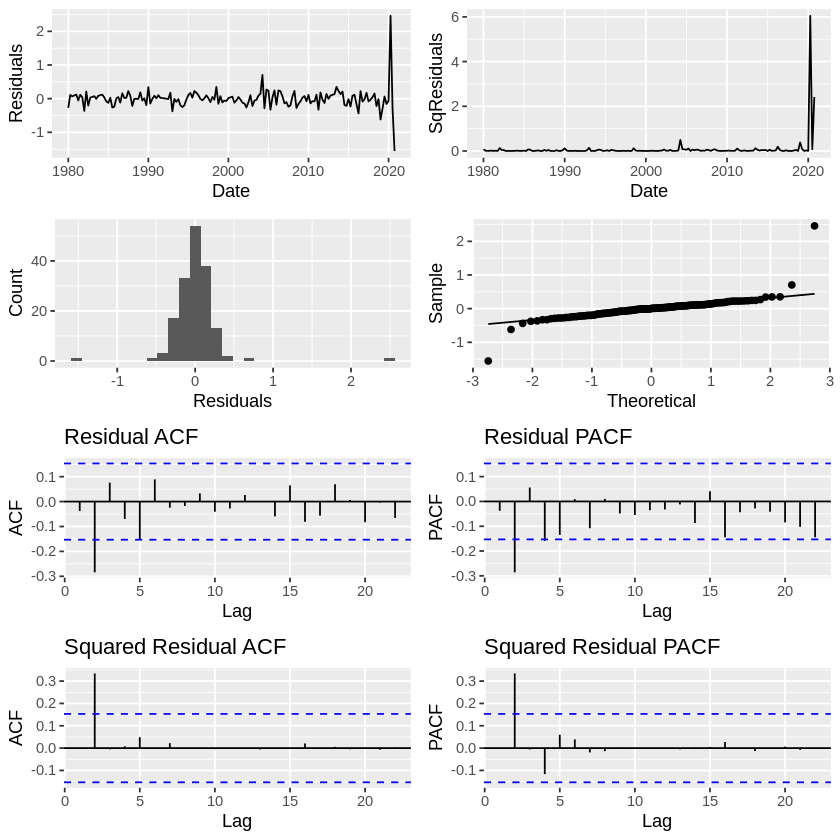

In [84]:
best_order <- ugarch_comp$Final[1,1:4] %>% as.numeric
spec <- ugarchspec(variance.model=list(garchOrder=c(best_order[3:4])),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model <- ugarchfit(spec, train_resid$Residuals, solver = 'hybrid')
residual_analysis(ugarch_model, train_resid$Date)
box_tests(ugarch_model, sum(best_order))

# Forecasting

In [61]:
splines_forecast <- predict(splines_model, newdata = test_splines)
test_resid <- test_splines$Value - splines_forecast 

## ARIMA

PM =  14.99321

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.268979,1.31076,1.268979,94.46092,94.46092


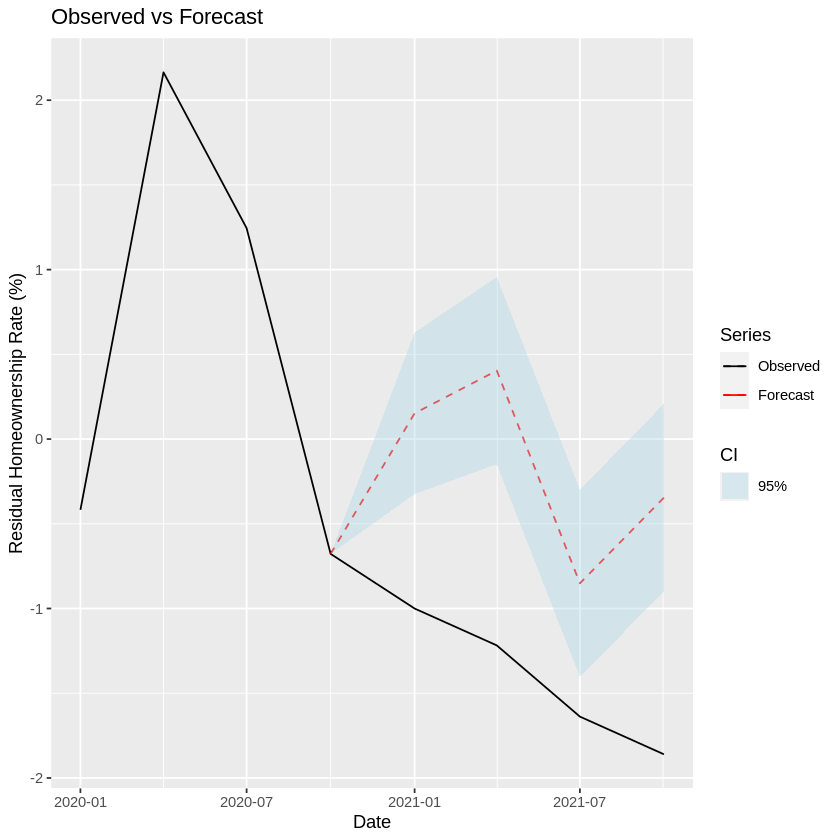

In [62]:
arima_fc <- forecast_arima(arima_model, homeownership$Date, test_resid, test_split, 95,
                    y_lab = "Residual Homeownership Rate (%)")
arima_fc$plot
fc_data <- tail(arima_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 1

PM =  3.450158

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.6194031,0.6287751,0.6194031,44.3459,44.3459


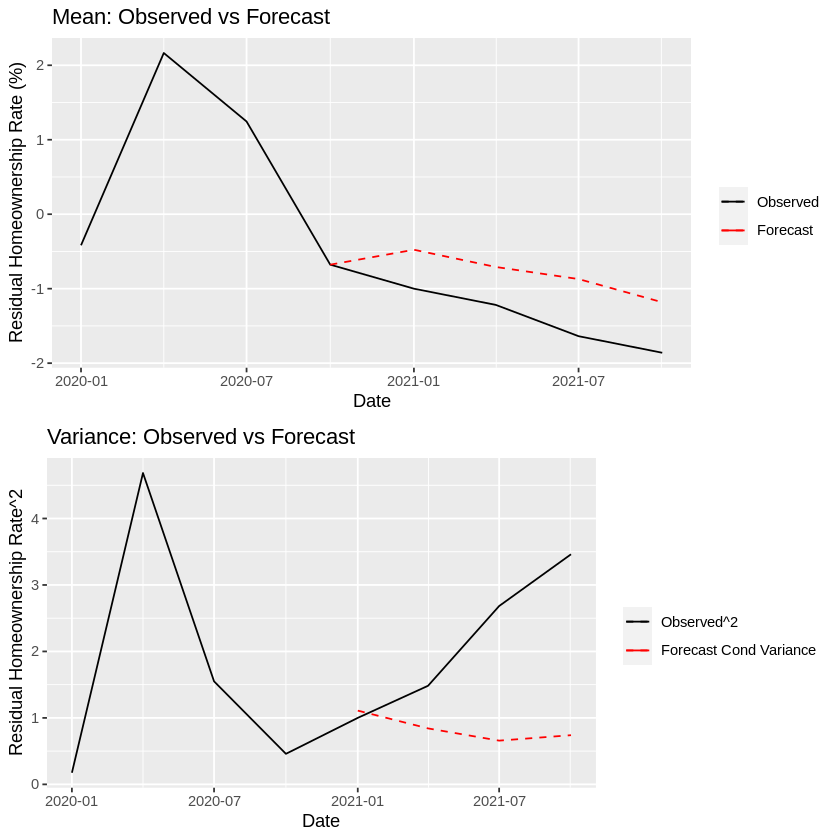

In [75]:
ugarch_fc <- forecast_ugarchroll_future(ugarch_model, homeownership$Date, test_resid, test_split, 
                                         y_lab = c("Residual Homeownership Rate (%)", "Residual Homeownership Rate^2"))
ugarch_fc$plot
fc_data <- tail(ugarch_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## Combined Model

SPLINES


[1] 215.708

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.429157,1.4687,1.429157,-2.18267,2.18267


ARIMA


[1] 171.8092

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.268979,1.31076,1.268979,-1.937102,1.937102


UGARCH


[1] 39.53581

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.6194031,0.6287751,0.6194031,-0.9458968,0.9458968


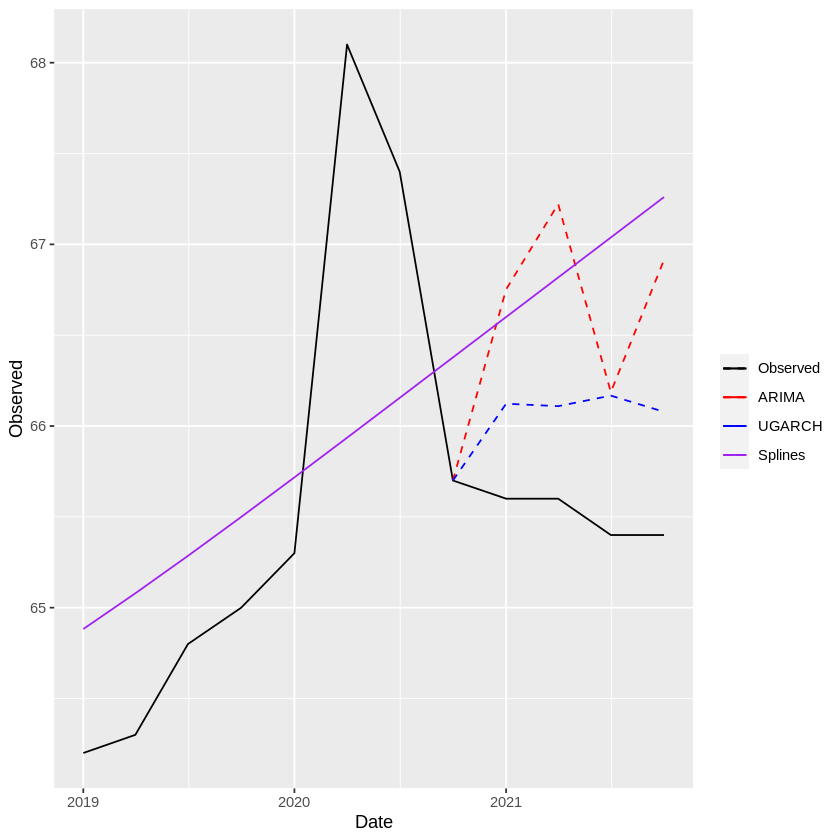

In [85]:
combined_fc <- data.frame(Date = head(homeownership$Date, -test_split),
                          Observed = head(homeownership$Value, -test_split),
                          ARIMA = rep(NA, nrow(train_splines)), 
                          UGARCH = rep(NA, nrow(train_splines)))
combined_fc$ARIMA[nrow(combined_fc)] <- combined_fc$Observed[nrow(combined_fc)]
combined_fc$UGARCH[nrow(combined_fc)] <- combined_fc$Observed[nrow(combined_fc)]

tmp <- data.frame(Date = tail(homeownership$Date, test_split),
                  Observed = tail(homeownership$Value, test_split),
                  ARIMA = tail(arima_fc$data$Forecast, test_split) + splines_forecast,
                  UGARCH = tail(ugarch_fc$data$Forecast, test_split) + splines_forecast)
combined_fc <- combined_fc %>% rbind(tmp)
combined_fc <- cbind(combined_fc, Splines = c(fitted(splines_model), splines_forecast))

combined_fc %>% tail(12) %>% ggplot() +
  geom_line(aes(x = Date, y = Observed, color = "Observed")) +
  geom_line(aes(x = Date, y = ARIMA, color = "ARIMA"), linetype = "dashed") +
  geom_line(aes(x = Date, y = UGARCH, color = "UGARCH"), linetype = "dashed") +
  geom_line(aes(x = Date, y = Splines, color = "Splines")) +
  scale_color_manual("", values = c("Observed" = "black", "ARIMA" = "red",
                                    "UGARCH" = "blue",
                                    "Splines" = "purple"))

fc_only <- tail(combined_fc, test_split)

cat("SPLINES\n")
prec_measure(fc_only$Observed, fc_only$Splines)
accuracy(fc_only$Splines, x = fc_only$Observed)

cat("ARIMA\n")
prec_measure(fc_only$Observed, fc_only$ARIMA)
accuracy(fc_only$ARIMA, x = fc_only$Observed)

cat("UGARCH\n")
prec_measure(fc_only$Observed, fc_only$UGARCH)
accuracy(fc_only$UGARCH, x = fc_only$Observed)
